In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as skm

In [229]:
df = pd.read_excel('../data/MERGED_DATA_INTERPOLATED2.xlsx', sheet_name='MERGE')
df.head()

,LOC_CODE,DATUM,TIJD,ZS [mg/l],ZICHT [dm],T [oC],SiO2 [umol/L],SALNTT [DIMSLS],PO4 [umol/L],pH [DIMSLS],...,Pde,Plo,Dpu,Rte,Fja,Hak,Mhe,Dno,Dat,interpolated_columns
0,DANTZGT,1990-01-10,15:00:00,135.0,2.0,4.0,20.178571,29.19,1.645161,7.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
1,DANTZGT,1990-02-06,13:40:00,295.0,0.5,6.0,19.803571,27.37,1.177419,7.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['SiO2 [umol/L]', 'PO4 [umol/L]', 'pH [DIMSLS]..."
2,DANTZGT,1990-03-08,13:45:00,103.0,3.0,7.3,19.428571,24.99,0.709677,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
3,DANTZGT,1990-04-04,10:00:00,113.0,3.0,8.2,6.285714,28.79,0.806452,8.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
4,DANTZGT,1990-05-09,15:30:00,20.0,11.0,17.4,1.714286,33.28,1.161290,8.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]


---

In [230]:
columns = list(df.columns)
location_names = df["LOC_CODE"].unique()

print("Columns: \n", columns)
print("\nLocation names: \n", location_names)
df['DATUM'] = pd.to_datetime(df['DATUM'])

# we drop the "time" and "zicht" columns
time_loc_columns = ['LOC_CODE', 'DATUM']
abiotic_columns = ['ZS [mg/l]', 'T [oC]', 'SiO2 [umol/L]', 'SALNTT [DIMSLS]', 'PO4 [umol/L]', 'pH [DIMSLS]', 'NO3 [umol/L]', 'NO2 [umol/L]', 'NH4 [umol/L]', 'E [/m]', 'CHLFa [ug/l]']

abiotic_df = df[time_loc_columns + abiotic_columns]

abiotic_df.head()

Columns: 
 ['LOC_CODE', 'DATUM', 'TIJD', 'ZS [mg/l]', 'ZICHT [dm]', 'T [oC]', 'SiO2 [umol/L]', 'SALNTT [DIMSLS]', 'PO4 [umol/L]', 'pH [DIMSLS]', 'NO3 [umol/L]', 'NO2 [umol/L]', 'NH4 [umol/L]', 'E [/m]', 'CHLFa [ug/l]', '    Q', 'PAR [J/m2d]', 'PAR [kJ/m2d]', 'kPAR_7d', 'kPAR_14d', 'DIN', 'DIN:SRP', 'DIN:SI', 'SRP:SI', 'IM [Jm2d]', 'Agl', 'Dbr', 'Ezo', 'Gde', 'Oau', 'Omo', 'Orh', 'Osi', 'Ram', 'Rse', 'Tec', 'Tle', 'Tni', 'Tro', 'Dle', 'Etr', 'Gfl', 'Gsp', 'Nsc', 'Pbi', 'Pbr', 'Pha', 'Stu', 'Kgl', 'Oro', 'Tor', 'Cdi', 'Cra', 'Ore', 'Ata', 'Cfu', 'Cgr', 'Lan', 'Pcl', 'Pmi', 'Pos', 'Pse', 'Cden', 'Aco', 'Dip', 'Csu', 'Mnu', 'Pco', 'Cdeb', 'Cwa', 'Pba', 'Dac', 'Ptr', 'Lun', 'Nsi', 'Rst', 'Pst', 'Acn', 'Tno', 'Ccu', 'Pan', 'Gfa', 'Hta', 'Dsp', 'Psu', 'Cei', 'Ndi', 'Cda', 'Dro', 'Cha', 'Pac', 'Cau', 'Coc', 'Pte', 'Edu', 'Mpe', 'Pde', 'Plo', 'Dpu', 'Rte', 'Fja', 'Hak', 'Mhe', 'Dno', 'Dat', 'interpolated_columns']

Location names: 
 ['DANTZGT' 'DREISR' 'GOERE6' 'GROOTGND' 'HANSWGL' 'HUIBGOT' 'L

,LOC_CODE,DATUM,ZS [mg/l],T [oC],SiO2 [umol/L],SALNTT [DIMSLS],PO4 [umol/L],pH [DIMSLS],NO3 [umol/L],NO2 [umol/L],NH4 [umol/L],E [/m],CHLFa [ug/l]
0,DANTZGT,1990-01-10,135.0,4.0,20.178571,29.19,1.645161,7.8,37.571429,3.714286,14.071429,0.751180,1.3
1,DANTZGT,1990-02-06,295.0,6.0,19.803571,27.37,1.177419,7.9,63.428571,2.892857,11.357143,11.391822,11.2
2,DANTZGT,1990-03-08,103.0,7.3,19.428571,24.99,0.709677,8.0,89.285714,2.071429,8.642857,1.364080,21.1
3,DANTZGT,1990-04-04,113.0,8.2,6.285714,28.79,0.806452,8.1,40.000000,2.000000,6.428571,1.037580,25.0
4,DANTZGT,1990-05-09,20.0,17.4,1.714286,33.28,1.161290,8.3,0.214286,0.142857,1.928571,0.738760,10.2


## Creating train and test split

In [231]:
location_groups = abiotic_df.groupby("LOC_CODE")

train_test_dict = {}
for name, loc_df in location_groups:
    # extract year and month and put inside new column
    loc_df['YearMonth'] = loc_df['DATUM'].dt.to_period('M')
    
    loc_df = loc_df.drop(['DATUM', 'LOC_CODE'], axis=1)
    
    # calculate mean over month
    loc_df_mean = loc_df.groupby('YearMonth').mean().reset_index()
    
    train_test_dict[name] = loc_df_mean


## Scaling data before use

In [232]:
def scale_data(data, parameter_columns):
    # we gotta normalize the values for the different variables prior to analysis
    abio_data_scaler = MinMaxScaler()

    abio_data_scaler.fit(data[parameter_columns])
    data[parameter_columns] = abio_data_scaler.transform(data[parameter_columns])

for loc_name, data in train_test_dict.items():
    scale_data(data, abiotic_columns)

## Transforming data into labeled data and creating train/test split

In [233]:
train_test_ratio = 0.7

def window_sampler(df, window, parameter_columns):
	X = []
	Y = []
	dates_Y = []
	for i in range(0, len(df) - window):
		history = []
		for j in range(0, window):
			history.append(list(df[parameter_columns].iloc[(i + j)]))
		X.append(history)
		Y.append(df[parameter_columns].iloc[i + window].values)
		dates_Y.append(df["YearMonth"].iloc[i + window])
	return np.array(X), np.array(Y), np.array(dates_Y)

# copying the dictionary before it gets split
full_data_dict = train_test_dict.copy()

for i, (loc_name, data) in enumerate(train_test_dict.items()):
	print(f"LOC_NAME: {loc_name} BUSY ({i}/{len(train_test_dict) - 1})")
	X, Y, dates_Y = window_sampler(data, 6, abiotic_columns)

	tuple_list = list(zip(X, Y))

	print("sample pairs: ", len(tuple_list))

	X, Y = zip(*tuple_list)

	train_x = np.asarray(X[:int(train_test_ratio * len(X))])
	train_y = np.asarray(Y[:int(train_test_ratio * len(Y))])
	train_dates = np.asarray(dates_Y[:int(train_test_ratio * len(Y))])

	test_x = np.asarray(X[int(train_test_ratio * len(X)):])
	test_y = np.asarray(Y[int(train_test_ratio * len(Y)):])
	test_dates = np.asarray(dates_Y[int(train_test_ratio * len(Y)):])

	train_test_dict[loc_name] = ((train_x, train_y, train_dates), 
							  	(test_x, test_y, test_dates))
	print(f"LOC_NAME: {loc_name} FINISHED\n")


LOC_NAME: DANTZGT BUSY (0/26)


sample pairs:  364
LOC_NAME: DANTZGT FINISHED

LOC_NAME: DREISR BUSY (1/26)
sample pairs:  365
LOC_NAME: DREISR FINISHED

LOC_NAME: GOERE6 BUSY (2/26)
sample pairs:  356
LOC_NAME: GOERE6 FINISHED

LOC_NAME: GROOTGND BUSY (3/26)
sample pairs:  362
LOC_NAME: GROOTGND FINISHED

LOC_NAME: HANSWGL BUSY (4/26)
sample pairs:  365
LOC_NAME: HANSWGL FINISHED

LOC_NAME: HUIBGOT BUSY (5/26)
sample pairs:  362
LOC_NAME: HUIBGOT FINISHED

LOC_NAME: LODSGT BUSY (6/26)
sample pairs:  365
LOC_NAME: LODSGT FINISHED

LOC_NAME: MARSDND BUSY (7/26)
sample pairs:  363
LOC_NAME: MARSDND FINISHED

LOC_NAME: NOORDWK10 BUSY (8/26)
sample pairs:  362
LOC_NAME: NOORDWK10 FINISHED

LOC_NAME: NOORDWK2 BUSY (9/26)
sample pairs:  358
LOC_NAME: NOORDWK2 FINISHED

LOC_NAME: NOORDWK20 BUSY (10/26)
sample pairs:  359
LOC_NAME: NOORDWK20 FINISHED

LOC_NAME: NOORDWK70 BUSY (11/26)
sample pairs:  359
LOC_NAME: NOORDWK70 FINISHED

LOC_NAME: ROTTMPT3 BUSY (12/26)
sample pairs:  274
LOC_NAME: ROTTMPT3 FINISHED

LOC_NAME: ROTT

## Defining the LSTM model

In [434]:
class MultivariateLSTM:
    def __init__(self, input_shape, output_dimensionality, LSTM_units=256, dropout_prob=0.2, loss="MeanSquaredError", chosen_metrics=[metrics.mean_squared_error,
                    metrics.mean_absolute_error], optimizer="Adam", activation="linear"):
    
        self.output_dimensionality = output_dimensionality
        self.input_shape = input_shape
        self.location_name = None

        self.period_converter = np.vectorize(lambda x: x.year + ((x.month - 1) / 12))

        self.model = keras.Sequential()
        self.model.add(Input(shape=(input_shape[0], input_shape[1])))
        self.model.add(keras.layers.LSTM(LSTM_units))
        self.model.add(keras.layers.Dropout(dropout_prob))
        self.model.add(keras.layers.Dense(output_dimensionality, activation=activation))
        self.model.compile(loss = loss, metrics=chosen_metrics, optimizer=optimizer)
        self.model.summary()
    
    def train(self, data_dict, location_name, epochs=50):
        X_train = data_dict[location_name][0][0]
        Y_train = data_dict[location_name][0][1]

        self.location_name = location_name

        return self.model.fit(X_train, Y_train, epochs=epochs)
    
    def predict(self, data_dict, plot=False, plot_settings=((4, 8), 2)):
        if self.location_name is None:
            print("Train the model first using model.train(data_dict, location_name, [epochs])")
            return

        X_test, y_test, dates = data_dict[self.location_name][1]

        dates = self.period_converter(dates)

        predicted_values = self.model.predict(X_test)

        if plot is not False and plot in ["All", "Extrapolated"]:
            self.plot_predicted_data(data_dict[self.location_name][0], predicted_values, y_test, dates, abiotic_columns, plot, *plot_settings)

        return predicted_values

    def plot_predicted_data(self, train_tuple, predicted_values, actual_values, dates, columns, plot, subplotsize=(4, 8), colcount=2):
        if plot == "All":
            colcount = int(colcount / 2)
            _, Y_train, train_dates = train_tuple
            train_dates = self.period_converter(train_dates)

        rowcount = int(math.ceil(len(columns) / colcount))
    
        fig, ax = plt.subplots(rowcount, colcount, 
                            figsize=(subplotsize[1] * colcount, subplotsize[0] * rowcount))

        for i, column in enumerate(columns):
            if colcount == 1:
                subplot = ax[i // colcount]
            else:
                subplot = ax[i // colcount][i % colcount]

            if plot == "All":
                subplot.plot(train_dates, Y_train[:, i], 'g', label="Train Line")
            
            data = {
                'Predicted': predicted_values[:, i],
                'Actual': actual_values[:, i]
            }
            subplot.plot(dates, data['Actual'], label="Actual Line", linestyle='--')
            subplot.plot(dates, data['Predicted'], label="Predicted Line")
            subplot.legend()
            subplot.set_title(column)
    
    def extrapolate(self, data, month_count, columns, plot=False, lookback=8):
        if self.location_name is None:
            print("Train the model first using model.train(data_dict, location_name, [epochs])")
            return
        
        start_date = data.iloc[-1]["YearMonth"] + 1

        observation_dates = self.period_converter(data["YearMonth"])

        # dropping the yearmonth column of the data, since we will not use it
        data = data.drop("YearMonth", axis=1)

        # gathering the month labels for the extrapolated data
        extrapolation_dates = np.asarray(pd.period_range(start=start_date, periods=month_count, freq='M'))

        predictions = []
        data_history = np.asarray(data.tail(lookback))


        for month in range(month_count):
            print(f"Month {month + 1}/{month_count}")
            # extrapolating a single month
            prediction = self.model.predict(np.array([data_history]))

            # recording the predictions
            predictions.append(prediction)

            # adding the prediction to the history for further predictions
            data_history = np.delete(data_history, (0), axis=0)
            data_history = np.vstack([data_history, prediction])
        
        predictions = np.squeeze(np.asarray(predictions))
        
        if plot:
            fig, ax = plt.subplots(len(columns), 1, 
                            figsize=(8, 4 * len(columns)))

            extrapolation_dates = self.period_converter(extrapolation_dates)

            extrapolation_dates = np.insert(extrapolation_dates, 0, observation_dates[-1])

            extrapolation_units = np.vstack([data.to_numpy()[-1, :], predictions])

            for i, column in enumerate(columns):

                ax[i].plot(observation_dates, data.to_numpy()[:, i], label="Observations")
                ax[i].plot(extrapolation_dates, extrapolation_units[:, i], label="Extrapolation", linestyle='--')
                ax[i].legend()
                ax[i].set_title(column)

        
        return extrapolation_dates, predictions

    def eval(self, predicted_values, actual_values):
        for i, column in enumerate(abiotic_columns):
            print(f"{column}: ")
            print(f"     MSE: {skm.mean_squared_error(predicted_values[:, i], actual_values[:, i])}")
            print(f"     MAE: {skm.mean_absolute_error(predicted_values[:, i], actual_values[:, i])}")
            print(f"     R2:  {skm.r2_score(predicted_values[:, i], actual_values[:, i])}\n")
    

## Model Training

In [435]:
LSTM_dict = {}
for location_name in location_names[:1]:
    LSTM_model = MultivariateLSTM(input_shape=(train_x[0].shape[0], train_x[0].shape[1]), output_dimensionality=11)
    history = LSTM_model.train(train_test_dict, location_name, epochs=50)

    LSTM_dict[location_name] = LSTM_model

Model: "sequential_206"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_206 (LSTM)                 │ (None, 256)            │       274,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_206 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,259 (1.06 MB)

 Trainable params: 277,259 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1154 - mean_absolute_error: 0.2544 - mean_squared_error: 0.1154
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0424 - mean_absolute_error: 0.1571 - mean_squared_error: 0.0424 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0319 - mean_absolute_error: 0.1332 - mean_squared_error: 0.0319
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0283 - mean_absolute_error: 0.1299 - mean_squared_error: 0.0283 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0237 - mean_absolute_error: 0.1118 - mean_squared_error: 0.0237 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0206 - mean_absolute_error: 0.1065 - mean_squared_error: 0.0206 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0201 - mean_absolute_error: 0.1054 - mean_squared_error: 0.0201 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0203 - mean_absolute_error: 0.1053 - mean_squared_error: 0.0203 
Epoch 9/50
8/8 ━━

## Plotting results

All trained models will be saved inside the `LSTM_dict` dictionary variable. you can acces an individual model by indexing on the location name.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


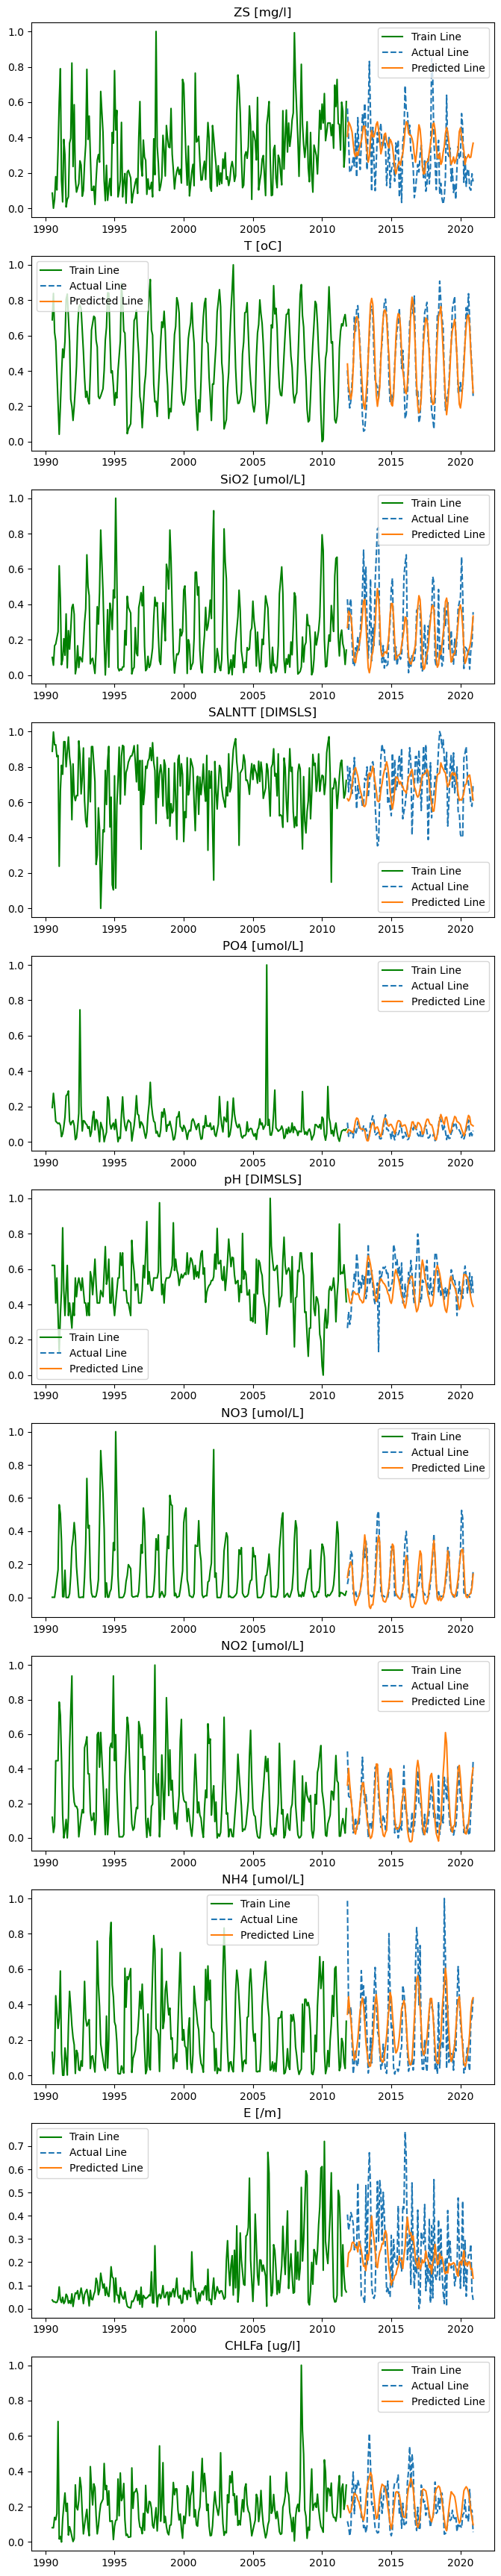

In [436]:
predicted_values = LSTM_dict["DANTZGT"].predict(train_test_dict, plot="All")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


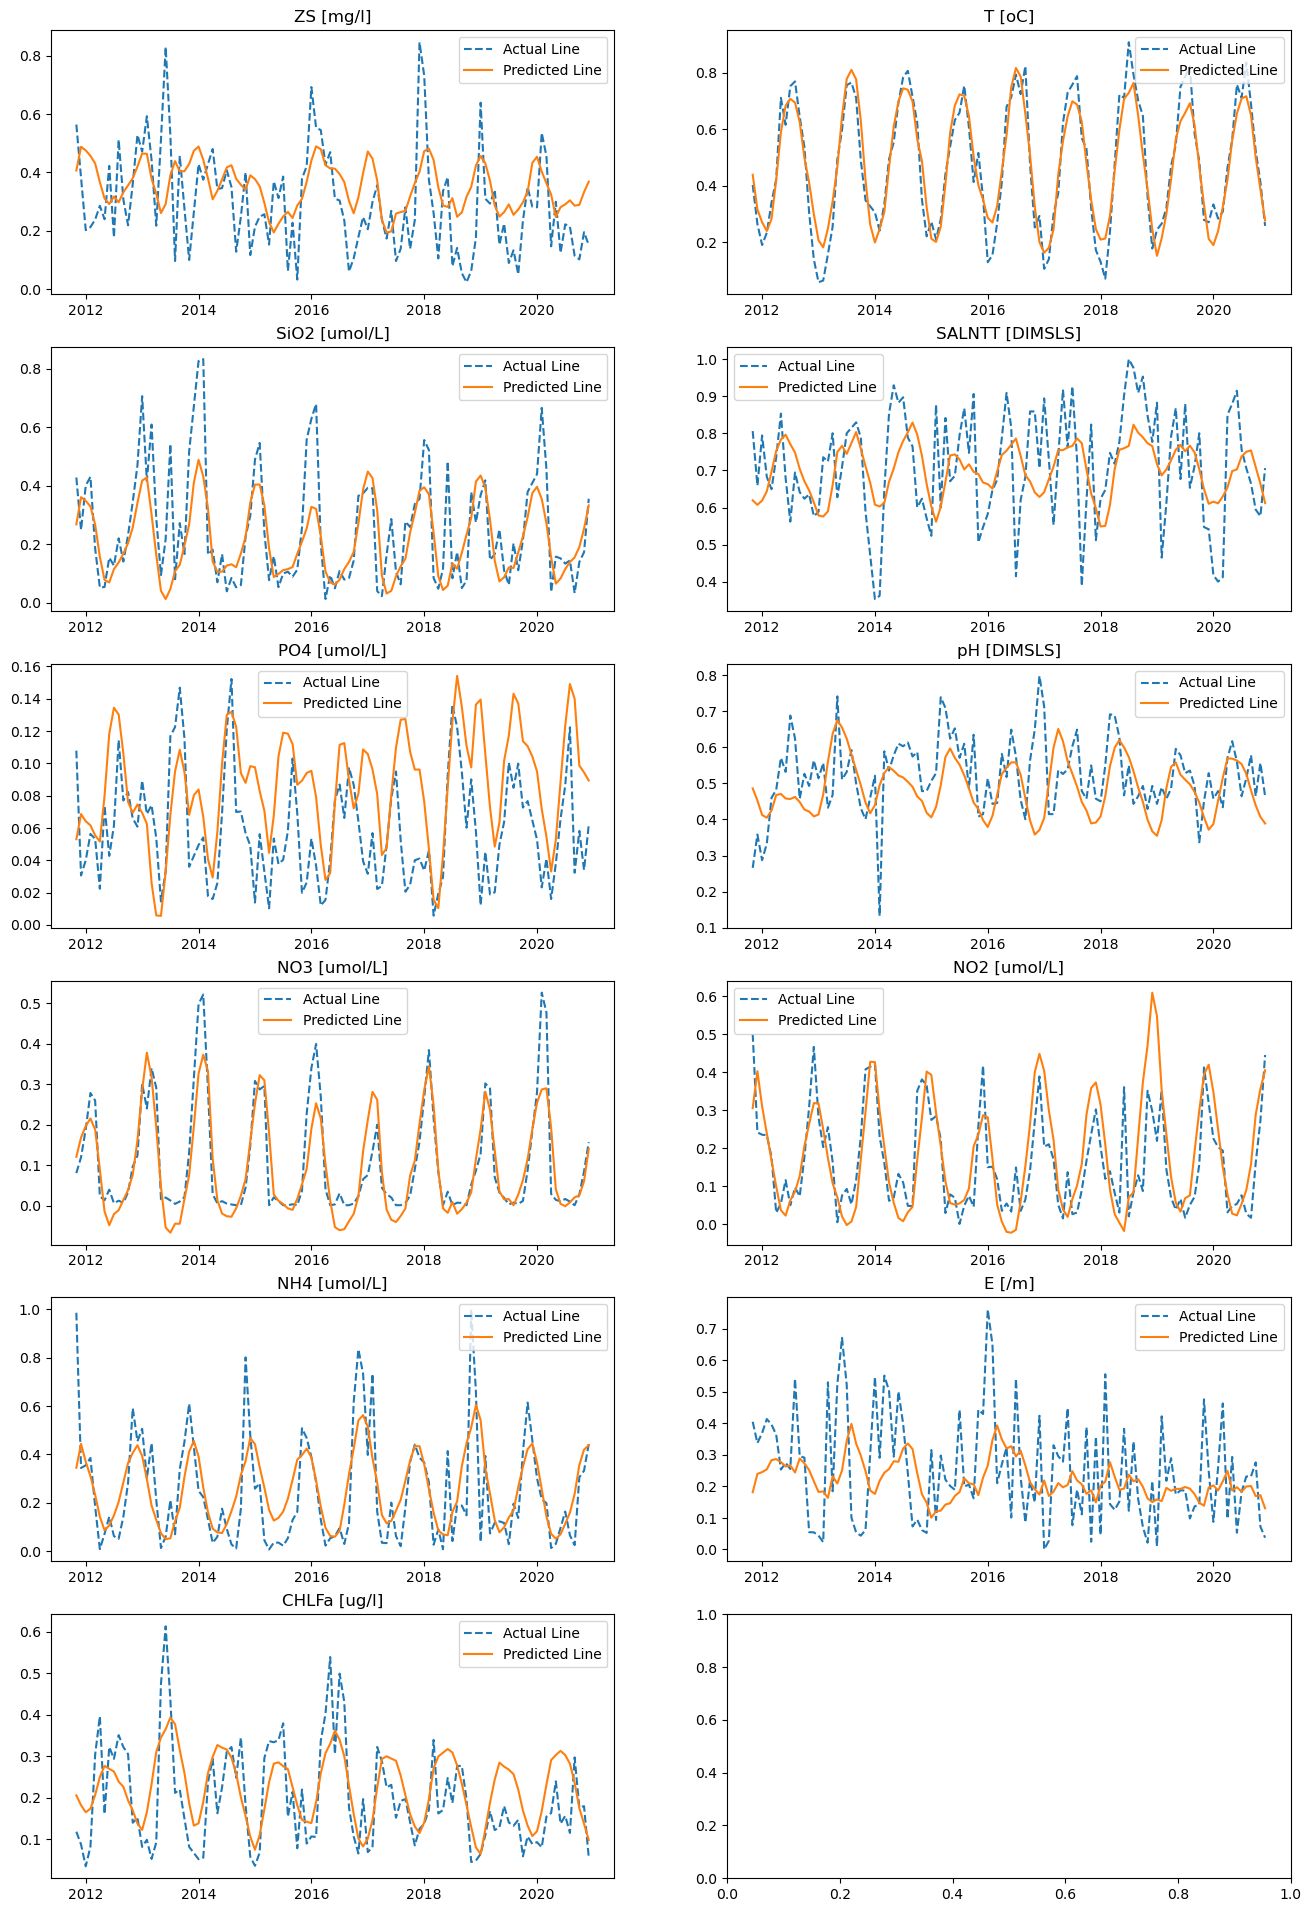

In [437]:
predicted_values = LSTM_dict["DANTZGT"].predict(train_test_dict, plot="Extrapolated")

## Evaluation

In [438]:
_, y_test, _ = train_test_dict["DANTZGT"][1]

LSTM_dict["DANTZGT"].eval(predicted_values, y_test)

ZS [mg/l]: 
     MSE: 0.027715203550600902
     MAE: 0.13723900847698187
     R2:  -3.6321740953896633

T [oC]: 
     MSE: 0.005861101668138948
     MAE: 0.0637308636257424
     R2:  0.845002895903312

SiO2 [umol/L]: 
     MSE: 0.0205925113438992
     MAE: 0.1035284851489139
     R2:  -0.3697065225637901

SALNTT [DIMSLS]: 
     MSE: 0.019149501434068975
     MAE: 0.11340473904015566
     R2:  -3.1548773156760905

PO4 [umol/L]: 
     MSE: 0.0018621948156044316
     MAE: 0.034834465843891216
     R2:  -0.6691358509089018

pH [DIMSLS]: 
     MSE: 0.01300356427813293
     MAE: 0.0871297169565617
     R2:  -1.3487074479599306

NO3 [umol/L]: 
     MSE: 0.004449091243212434
     MAE: 0.04665946018425861
     R2:  0.6923473787454792

NO2 [umol/L]: 
     MSE: 0.010413641507085708
     MAE: 0.07649213339183115
     R2:  0.5151827658915527

NH4 [umol/L]: 
     MSE: 0.024903404997818897
     MAE: 0.1121690163971624
     R2:  -0.20963410834914487

E [/m]: 
     MSE: 0.030683847695618337
     MAE: 0

## Extrapolation

Month 1/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Month 2/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Month 3/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Month 4/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Month 5/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Month 6/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Month 7/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Month 8/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Month 9/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Month 10/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Month 11/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Month 12/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Month 13/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Month 14/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Month 15/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Month 16/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Month 17/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Month 18/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Month 19/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Month 20/24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Month 21/

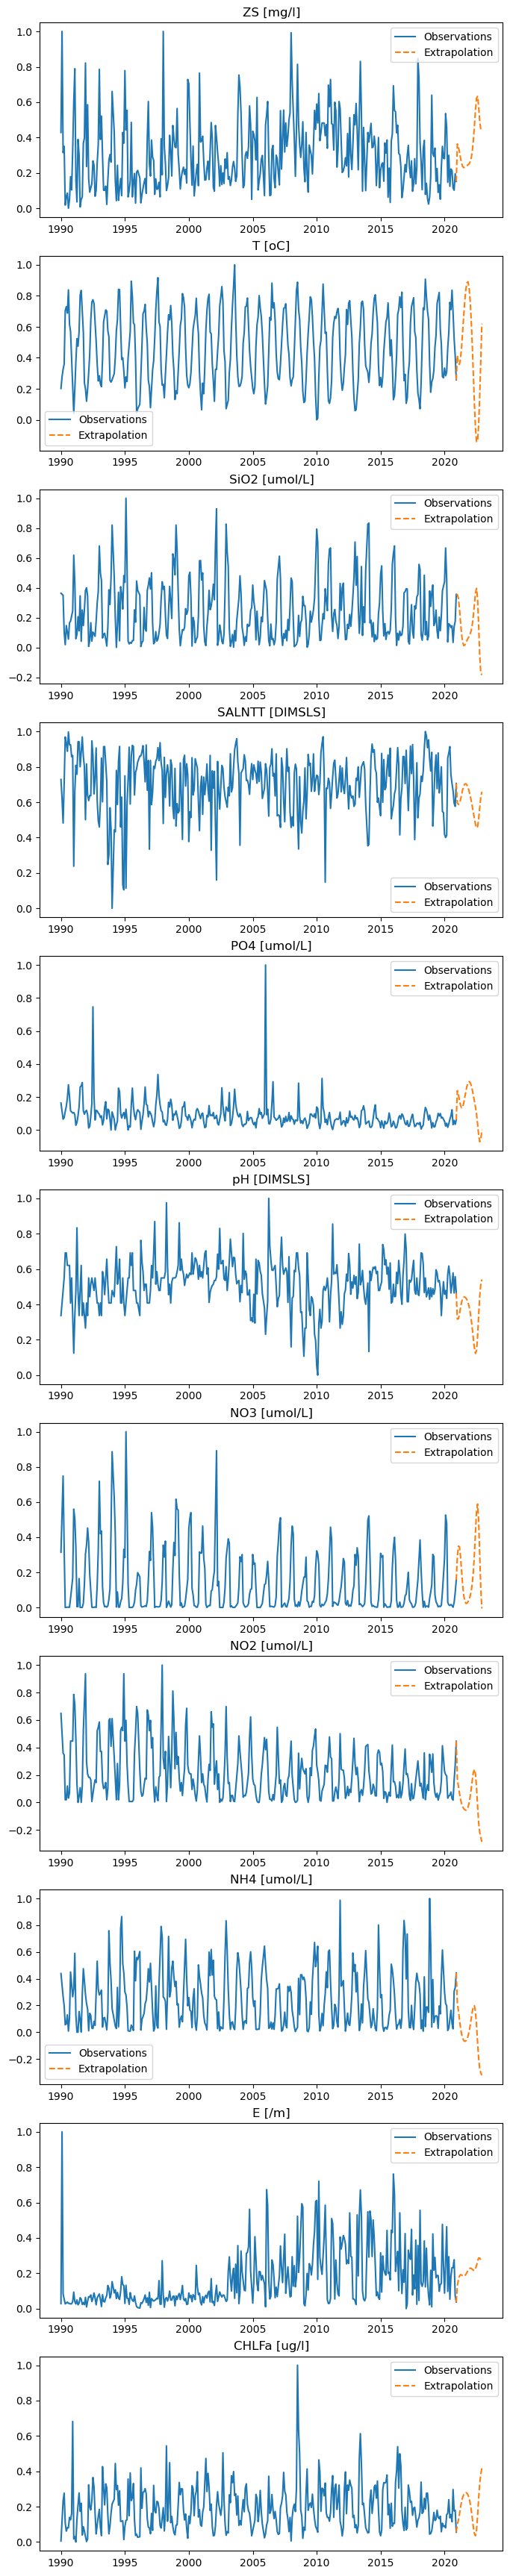

In [444]:
month_labels, predictions = LSTM_dict["DANTZGT"].extrapolate(full_data_dict["DANTZGT"], 24, abiotic_columns, plot=True, lookback=300)